# Bee Colony Optimization - Student Programming Task

presented by: Lina Lazik, Sönke Lülf, Hendrik Schmidt

### Context description:

With the help of this BCO algorithm you guys will plan the positional structure of hospitals for a small (imaginary) country.
You will have the coordinates with the potential properties of all places where you could place a hospital. All the places which will not be claimed as hospitals will be become a residence for the people. 
And instead of randomly assigning properties places to hospitals, you will have to make sure that every future houshold will have proper acces to a hospital close by.

In [ ]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import visualization

locations = visualization.get_locations()
num_nodes = len(locations)

# hyperparameters for the BCO algorithm
num_bees = 70                                                                                           #one bee is the equivalent of a hospital location proposition
num_nodes = len(locations)                                                                              #amount of property locations
NC = 30                                                                                                 #number of iterations
p_centers = 5                                                                                           #amount of hospital locations
hive = np.array([np.random.choice(num_nodes,p_centers,replace=False) for _ in range(num_bees)])         #random initialization of the bees
fitness = np.zeros((num_bees,))                                                                         #initialization of fitness                                                       #initialization of fitness

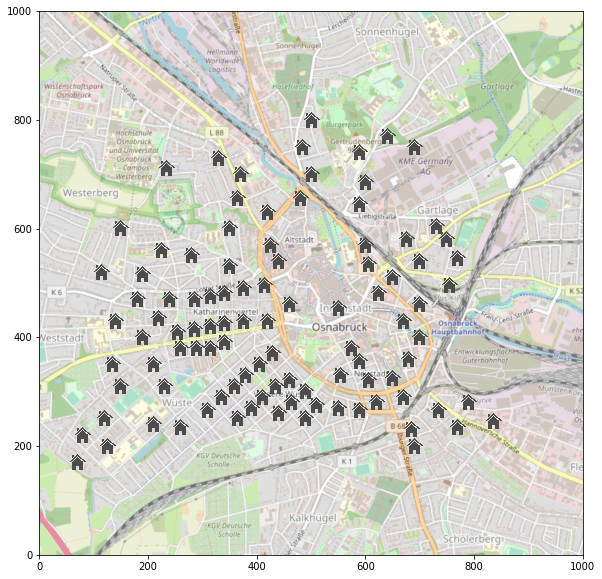

In [ ]:
visualization.visualize_solution(locations, [])

[Provided]

Here the properties locations get randomly assigned coordinates. From these locations our centers get randomly selected.

The distance between two locations is represented in a matrix. In Dc the distances are sorted from lowest to highest (left to right) and Ds displayes the normal matrix but with their rank in distance (lowest to highest).

In [ ]:
#locations = np.random.randint(0,1000,(num_nodes,2))


#random_centers_indices = np.random.choice(p_centers,2,replace=False)

distance = np.zeros((num_nodes,num_nodes))
for i, row in enumerate(distance):
  for j, cell in enumerate(row):
    distance[i,j] = round(math.sqrt((locations[i,0]-locations[j,0])**2 + (locations[i,1]-locations[j,1])**2),2)

dc = np.zeros((num_nodes,num_nodes))
ds = np.zeros((num_nodes,num_nodes), dtype=int)

for i, row in enumerate(distance):
  dc[i]=np.sort(row)
  ds[i]=np.argsort(row)

[Provided]

The critical distance provides the information which distance between a houshold location and the nearest hospital center is the maximum distance. To ensure that every houshold has a hospital near by.

In [ ]:
def critical_pair(centers):
  """
    Finds the critical pair in a given set of nodes.
    param:  centers; list, nodes that were chosen as a center
            locations; list, the nodes in the graph
    return: cpair; tuple, location and center that make up the critical pair
            cdist; float, the critical distance
  """
  cdist= 0
  cpair=(0,0) #############################################################
  for i, loc in enumerate(locations):
    if not(i in centers):
      for j,val in enumerate(ds[i]):
        if val in centers:
          dist=dc[i,j]
          if dist > cdist:
            cdist =dc[i,j]
            cpair=(i,val) #(location, center)
          break
  return cpair, cdist

### [Programming Task 1]

Before we can check if the locations of the hospitals are the best ones from all the locations we need to temporally increase the number of hospital location, expanding the amount of number for hospital centers. 
Since you guys now have to many hospital centers you need to compare which hospitals can be removed from the set, without drastically increasing the critical distance.

Keep in mind, that at the end of this function, you should only have 5(or the number you picked at the beginning) centers.


In [ ]:
def expand_centers(centers):
    """
      Finds the critical pair in a given set of nodes.
      param:  centers; ndarray, nodes that were chosen as a center
              p_centers; int, the number of centers
              num_nodes; int, the number of nodes in the graph
      return: expanded_centers; ndarray, the expanded centers
    """
    q = random.randint(1,min(p_centers,(num_nodes//10)))
    q_centers = np.empty((q,))
    for i in range(q):
        status = True
        while status:
            new_c = np.random.randint(0,num_nodes)
            if new_c not in centers and new_c not in q_centers:
                status = False
        q_centers[i] = new_c
    q_centers = q_centers.astype('int')
    expanded_centers = np.append(centers, q_centers)
  
    critical_pairs = np.array([critical_pair(np.concatenate((expanded_centers[:i], expanded_centers[i+1:])))[1] for i in range(p_centers+q)])
    expanded_centers = np.delete(expanded_centers, np.argsort(critical_pairs)[:q])

    if (critical_pair(expanded_centers)[1]) > (critical_pair(centers)[1]):
        return centers
    
    return expanded_centers

### [Programming Task 2.1]

Normalize the values.

In [ ]:
def normalize_value(objective, value, max_fitness, min_fitness):
    """
      This function normalizes the fitness value of a bee's partial solution depending on whether the fitness function is supposed to be minimized or maximized.
      
      param:  objective; string, indicates what kind of problem we are dealing with
              value; float, the current bees fitness value
              max_fitness; float, the highest fitness score
              min_fitness; float, the lowest fitness score
      
      return: normalized_fitness; float, the normalized fitness score
    """
                               
    if objective == "min":
        return (max_fitness - value) / (max_fitness - min_fitness)
    elif objective == "max":
        return (value - max_fitness) / (max_fitness - min_fitness)
    else:
        return 0

### [Programming Task 2.2]



In [ ]:
def create_roulette_wheel(recruiters, fitness):
    """
      This function calculates the probability that a recruiters' partial solution is choosen by an uncommitted bee.

      param:  recruiters; list, stores all the bees that have become recruiters. The bees are represented by their index in the hive
              fitness; ndarray, all of the bees' fitness values
              
      return: roulette_wheel; list, holds the probability for each recruiter that his solution will be chosen by the uncommitted bees
    """
    total = sum(fitness[ind_rec] for ind_rec in recruiters)
    return [fitness[ind_rec] / total for ind_rec in recruiters]

### [Provided]

Here every suggestion tries to add a little variety to their idea, by expanding the centers.

In [ ]:
def forward_pass(hive):
    """
      This function implements the forward pass for the BCO. Each bee expands its centers and stores the new solution

      param: recruiters; list, stores all the bees that have become recruiters. The bees are represented by their index in the hive
             fitness; ndarray, all of the bees' fitness values
             
      return: roulette_wheel; list, holds the probability for each recruiter that his solution will be chosen by the uncommitted bees
    """
    for ind_bee in range(num_bees):
        hive[ind_bee] = expand_centers(hive[ind_bee])
        

### [Programming Task 3]

In [ ]:
def backward_pass(objective, nc, hive):
    """
      This function implements the backward pass for the BCO algorithm. It proceeds in the following steps:
          1. It calculates the fitness for all the bees' solutions and identifies minimum and maximum values.
          2. For each bee, it calculates the probability that it will stick with it's own function (loyalty) and decides
             whether they become uncommitted (exploration) or a recruiter (exploitation)
          3. For every uncommitted bee, it decides which recruiter they will follow.

      param: objective; string, indicates what kind of problem we are dealing with
             nc; int, the number of the current iteration
             hive; ndarray, all the bees in one place

      return: min_fitness; float, the smallest critical distance found so far and therefore the best solution
              best_bee; ndarray, the best bee's solution
    """
    fitness = np.array([critical_pair(bee)[1] for bee in hive])
    max_fitness = np.amax(fitness)
    min_fitness = np.amin(fitness)
    min_index = np.argmin(fitness)
    norm_max_fitness = np.amax(np.array([normalize_value(objective, fit, max_fitness, min_fitness) for fit in fitness]))
    recruiters = []
    uncomitted = []
        
    # compute the loyalty decision for each bee depending on whether the objective is to minimize or to maximize
    # the fitness function 
    loyalty = 0  
    u = nc
    for bee in range(num_bees):
        loyalty = math.exp(-((norm_max_fitness - normalize_value(objective, fitness[bee], max_fitness, min_fitness)) / u**1/2))
        if random.random() > loyalty:
            uncomitted.append(bee)
        else:
            recruiters.append(bee)
    # create the roulette wheel which will be used by the uncommitted bees to decide which recruiter they will
    # follow
    roulette_wheel = create_roulette_wheel(recruiters, fitness)                    
    for ind_un in uncomitted:
        for ind_rec, recruiter in enumerate(recruiters):
            if random.random() < roulette_wheel[ind_rec]:
                hive[ind_un] = hive[recruiter]

    return min_fitness, hive[min_index]

### [Programming Task]
This is where you put everything together.

??? Auch providen, damit die wirklich sehen können ob deren Code klappt? 

In [ ]:
def BCO():
  best = []
  best_bee = []
  for i in range(NC):
    forward_pass(hive)
    curr_best, curr_bee = backward_pass("min", i+1, hive) 
    best.append(curr_best)
    best_bee.append(curr_bee)
    print(f"The best bee in iteration {i} has a score of: {curr_best}")  
  return best_bee[NC-1]        

The best bee in iteration 0 has a score of: 245.2
The best bee in iteration 1 has a score of: 220.06
The best bee in iteration 2 has a score of: 220.06
The best bee in iteration 3 has a score of: 217.08
The best bee in iteration 4 has a score of: 215.87
The best bee in iteration 5 has a score of: 215.87
The best bee in iteration 6 has a score of: 215.87
The best bee in iteration 7 has a score of: 213.6
The best bee in iteration 8 has a score of: 205.91
The best bee in iteration 9 has a score of: 205.91
The best bee in iteration 10 has a score of: 205.91
The best bee in iteration 11 has a score of: 205.91
The best bee in iteration 12 has a score of: 205.55
The best bee in iteration 13 has a score of: 205.55
The best bee in iteration 14 has a score of: 205.55
The best bee in iteration 15 has a score of: 205.55
The best bee in iteration 16 has a score of: 205.55
The best bee in iteration 17 has a score of: 205.55
The best bee in iteration 18 has a score of: 205.55
The best bee in iteratio

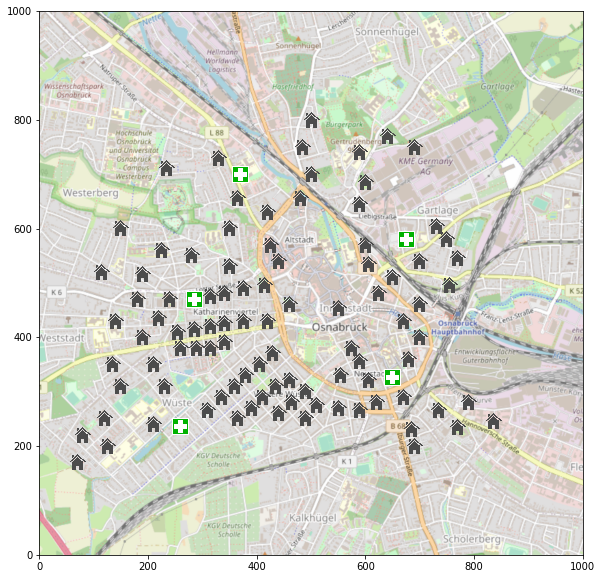

In [ ]:
best = BCO()
visualization.visualize_solution(locations,best)

In [ ]:
pair, dist = critical_pair(best)

In [ ]:
print(pair)
print(dist)

(63, 38)
205.55


In [ ]:
print(locations[63])
print(locations[38])

[835 245]
[700 400]
